In [1]:
from astropy.table import Table
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from minisom import MiniSom
import pickle
import os

In [2]:
b = []
for i in range(1, 5):
    dim = (2 * i + 1) * 10
    for j in range(1, 11):
        sigma = j
        for k in range(1, 11):
            rate = k / 10

            a = {}
            a["dim"] = dim
            a["sigma"] = sigma
            a["rate"] = rate
            b.append(a)

In [3]:
df_L3_info = Table.read('../dataset/L3_COSMOS2020_Richard_RefCat_2023DEC4_info.fits')
df_L3_info = df_L3_info.to_pandas()

In [4]:
L3_phot_data = np.loadtxt('../dataset/L3_COSMOS2020_Richard_RefCat_2023DEC4_averaged_phot102.txt')
phot_data = L3_phot_data[:,3::2]
phot_err_data = L3_phot_data[:,4::2]

In [5]:
def remove_low_SNR(data, data_err, info_data, mode, mag_cut):
    i_band = info_data["HSC_i_MAG"].values
    if mode == "mag_cut" or mode == "both":
        if type(mag_cut) == type(1):
            max_cut = np.mean(i_band) - np.std(i_band, ddof = 1) * mag_out
            data = data[i_band < max_cut]
            data_err = data[i_band < max_cut]
            info_data = info_data[np.logical_and((i_band < mag_cut[1]), (i_band > mag_cut[0]))]
        else:
            data = data[np.logical_and((i_band < mag_cut[1]), (i_band > mag_cut[0]))]
            data_err = data_err[np.logical_and((i_band < mag_cut[1]), (i_band > mag_cut[0]))]
            info_data = info_data[np.logical_and((i_band < mag_cut[1]), (i_band > mag_cut[0]))]
    if mode == "band_cut" or mode == "both":
        data = data[:, : len(data[0]) - 34]
        data_err = data_err[:, : len(data_err[0]) - 34]
        
    return data, data_err, info_data

In [6]:
def grid_search(data, file):
    n = 0
    with open(file, "rb") as fh:
        record = pickle.load(fh)
    if "som" not in record[-1]:
        for i in record:
            n += 1
            if "som" not in i:
                som = MiniSom(i["dim"], i["dim"], data.shape[1], sigma = i["sigma"], learning_rate = i["rate"])
                som.random_weights_init(data)
                som.train(data = data, num_iteration = 1, use_epochs = True) 
                i["topo_err"] = som.topographic_error(data)
                i["quan_err"] = som.quantization_error(data)
                i["som"] = som
                i["band_cut"] = len(data[0])
                i["mag_cut"] = len(data)
                i["preproc"] = "default"
                i["topo_err"] = som.topographic_error(data)
                i["quan_err"] = som.quantization_error(data)
                print(f"File: {file}, progress: {round(n / len(record) * 100, 2)}%, param: {[i["dim"], i["sigma"], i["rate"]]}", end = "\r")
                try:
                    with open(file, 'wb') as handle:
                        pickle.dump(record, handle, protocol=pickle.HIGHEST_PROTOCOL)
                except KeyboardInterrupt:
                    print('KeyboardInterrupt caught, data saved.')
    else:
        pass

In [12]:
def parameter_space(save):
    quan_map30 = np.zeros((19, 19))
    topo_map30 = np.zeros((19, 19))
    quan_map50 = np.zeros((19, 19))
    topo_map50 = np.zeros((19, 19))
    quan_map70 = np.zeros((19, 19))
    topo_map70 = np.zeros((19, 19))
    quan_map90 = np.zeros((19, 19))
    topo_map90 = np.zeros((19, 19))
    
    for j in os.listdir("D:/SPHEREx_SOM/record/grid_search/band_cut/"):
        if "check" in j or "diagram" in j:
            continue
        file = "D:/SPHEREx_SOM/record/grid_search/band_cut/" + j
        with open(file, "rb") as fh:
            record = pickle.load(fh)
            
        for i in record:
            if i["sigma"] < 1:
                x_index = i["sigma"] * 10 - 1
            elif i["sigma"] >= 1:
                x_index = i["sigma"] + 8
            if i["rate"] < 1:
                y_index = i["rate"] * 10 - 1
            elif i["rate"] >= 1:
                y_index = i["rate"] + 8
            if i["dim"] == 30:
                topo_map30[int(x_index), int(y_index)] = i["topo_err"]
                quan_map30[int(x_index), int(y_index)] = i["quan_err"]
            elif i["dim"] == 50:
                topo_map50[int(x_index), int(y_index)] = i["topo_err"]
                quan_map50[int(x_index), int(y_index)] = i["quan_err"]
            elif i["dim"] == 70:
                topo_map70[int(x_index), int(y_index)] = i["topo_err"]
                quan_map70[int(x_index), int(y_index)] = i["quan_err"]
            elif i["dim"] == 90:
                topo_map90[int(x_index), int(y_index)] = i["topo_err"]
                quan_map90[int(x_index), int(y_index)] = i["quan_err"]
            
    tick_i = [i + 0.5 for i in range(0, 19)]
    tick_f = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    topo_maps = [topo_map30, topo_map50, topo_map70, topo_map90]
    quan_maps = [quan_map30, quan_map50, quan_map70, quan_map90]
    
    plt.close()
    plt.figure(figsize = (30, 20))

    for i in range(1, 5):
        dim = (i * 2 + 1) * 10
        plt.subplot(220 + i)
        plt.hist(topo_maps[i - 1].reshape(-1), bins = 20)
        plt.xlabel("Topological Error", fontsize=20)
        plt.ylabel("# of Glaxies", fontsize=20)
    
    if save:
        plt.savefig(f"D:/SPHEREx_SOM/record/grid_search/band_cut/diagram/topo_err_dist.jpg", bbox_inches = "tight")    
    plt.show()

    plt.close()
    plt.figure(figsize = (30, 20))
    for i in range(1, 5):
        dim = (i * 2 + 1) * 10
        plt.subplot(220 + i)
        plt.hist(np.log10(quan_maps[i - 1]).reshape(-1), bins = 20)
        plt.xlabel("log(Quantization Error)", fontsize=20)
        plt.ylabel("# of Glaxies", fontsize=20)
        plt.yscale("log")
        
    if save:
        plt.savefig(f"D:/SPHEREx_SOM/record/grid_search/band_cut/diagram/quan_err_dist.jpg", bbox_inches = "tight")  
    plt.show()
    
    plt.close()
    plt.figure(figsize = (30, 20))
    for i in range(1, 5):
        dim = (i * 2 + 1) * 10
        plt.subplot(220 + i)
        plt.pcolor(topo_maps[i - 1], cmap = 'YlGn')
        plt.title(f"Topological Error (Dim: {dim}X{dim} / Cut: both)", fontsize=20)
        plt.xlabel("Rate", fontsize=20)
        plt.ylabel("Sigma", fontsize=20)
        plt.xticks(tick_i, tick_f, fontsize=15)
        plt.yticks(tick_i, tick_f, fontsize=15)
        plt.colorbar().ax.tick_params(labelsize=15)

    if save:
        plt.savefig(f"D:/SPHEREx_SOM/record/grid_search/band_cut/diagram/topo_err_para_space.jpg", bbox_inches = "tight")  
    plt.show()
    
    plt.close()
    plt.figure(figsize = (30, 20))
    for i in range(1, 5):
        dim = (i * 2 + 1) * 10
        plt.subplot(220 + i)
        plt.pcolor(np.log10(quan_maps[i - 1]), cmap = 'YlGn')
        plt.title(f"Quantizationl Error (Dim: {dim}X{dim} / Cut: both)", fontsize=20)
        plt.xlabel("Rate", fontsize=20)
        plt.ylabel("Sigma", fontsize=20)
        plt.xticks(tick_i, tick_f, fontsize=15)
        plt.yticks(tick_i, tick_f, fontsize=15)
        plt.colorbar().ax.tick_params(labelsize=15)

    if save:
        plt.savefig(f"D:/SPHEREx_SOM/record/grid_search/band_cut/diagram/quan_err_para_space.jpg", bbox_inches = "tight")  
    plt.show()

In [15]:
def visual_map(dim, sigma, rate, data, info_data, save = False):
    for j in os.listdir("D:/SPHEREx_SOM/record/grid_search/band_cut/"):
        if "check" in j or "diagram" in j:
            continue
        file = "D:/SPHEREx_SOM/record/grid_search/band_cut/" + j
        with open(file, "rb") as fh:
            record = pickle.load(fh)
        for k in record:
            if k["dim"] == dim and k["rate"] == rate and k["sigma"] == sigma:
                pass
            else:
                continue
            som = k["som"]
            
            density_map = np.zeros(dim ** 2).reshape(dim, dim)
            magnitude_map = np.zeros(dim ** 2).reshape(dim, dim)
            magnitude_map.fill(np.nan)
            z_map = np.zeros(dim ** 2).reshape(dim, dim)
            z_map.fill(np.nan)
            
            labels_map_1 = som.labels_map(data, [0] * len(data))
            labels_map_2 = som.labels_map(data, tuple(map(tuple, np.concatenate((np.expand_dims(info_data["HSC_i_MAG"].values, axis = 1), np.expand_dims(info_data["z_true"].values, axis = 1)), axis = -1))))
        
            for i in labels_map_1.keys():
                density_map[int(list(i)[0]), int(list(i)[1])] = labels_map_1[i][0]
            
            for i in labels_map_2.keys():
                properties = np.mean(np.array(list(labels_map_2[i].keys())), axis = 0)
                magnitude_map[int(list(i)[0]), int(list(i)[1])] = properties[0]
                z_map[int(list(i)[0]), int(list(i)[1])] = properties[1]
        
            print(f"Topological error: {som.topographic_error(data)}")
            print(f"Quantization error: {som.quantization_error(data)}")
    
            %matplotlib inline
            plt.close()
            plt.figure(figsize = (30, 20))
            plt.subplot(221)
            plt.pcolor(som.distance_map().T, cmap='YlGn')  # plotting the distance map as background
            plt.colorbar()
            plt.title("Distance map (U-matrix)")
        
            plt.subplot(222)
            plt.pcolor(density_map.T, cmap='YlGn')
            plt.colorbar()
            plt.title("Density Map")
        
            plt.subplot(223)
            plt.pcolor(magnitude_map.T, cmap="plasma" + "_r")
            plt.colorbar()
            plt.title("HSC I Magnitude Map")
        
            plt.subplot(224)
            plt.pcolor(z_map.T, cmap="plasma")
            plt.colorbar()
            plt.title("True Redshift Map")
            if save:
                plt.savefig(f"D:/SPHEREx_SOM/record/grid_search/band_cut/diagram/{dim}_{sigma}_{rate}.jpg", bbox_inches = "tight")
            
            plt.show()
        
            k["density"] = density_map
            k["magnitude"] = magnitude_map
            k["z"] = z_map

            try:
                with open(file, 'wb') as handle:
                    pickle.dump(record, handle, protocol=pickle.HIGHEST_PROTOCOL)
            except KeyboardInterrupt:
                print('KeyboardInterrupt caught, data saved.')

In [13]:
data, data_err, info_data = remove_low_SNR(data = phot_data, data_err = phot_err_data, info_data = df_L3_info, mode = "band_cut", mag_cut = [0, 22])
data = (data - np.mean(data, axis=0)) / np.std(data, axis=0)
data.shape

(29685, 68)

In [7]:
for j in os.listdir("D:/SPHEREx_SOM/record/grid_search/band_cut/"):
    if "check" in j:
        continue
    file = "D:/SPHEREx_SOM/record/grid_search/band_cut/" + j
    grid_search(data = data, file = file)

D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\minisom.py:540: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-2 * cross_term + input_data_sq + weights_flat_sq.T)


In [ ]:
parameter_space(save = True)

Topological error: 0.6754252989725451
Quantization error: 2.854764668550666


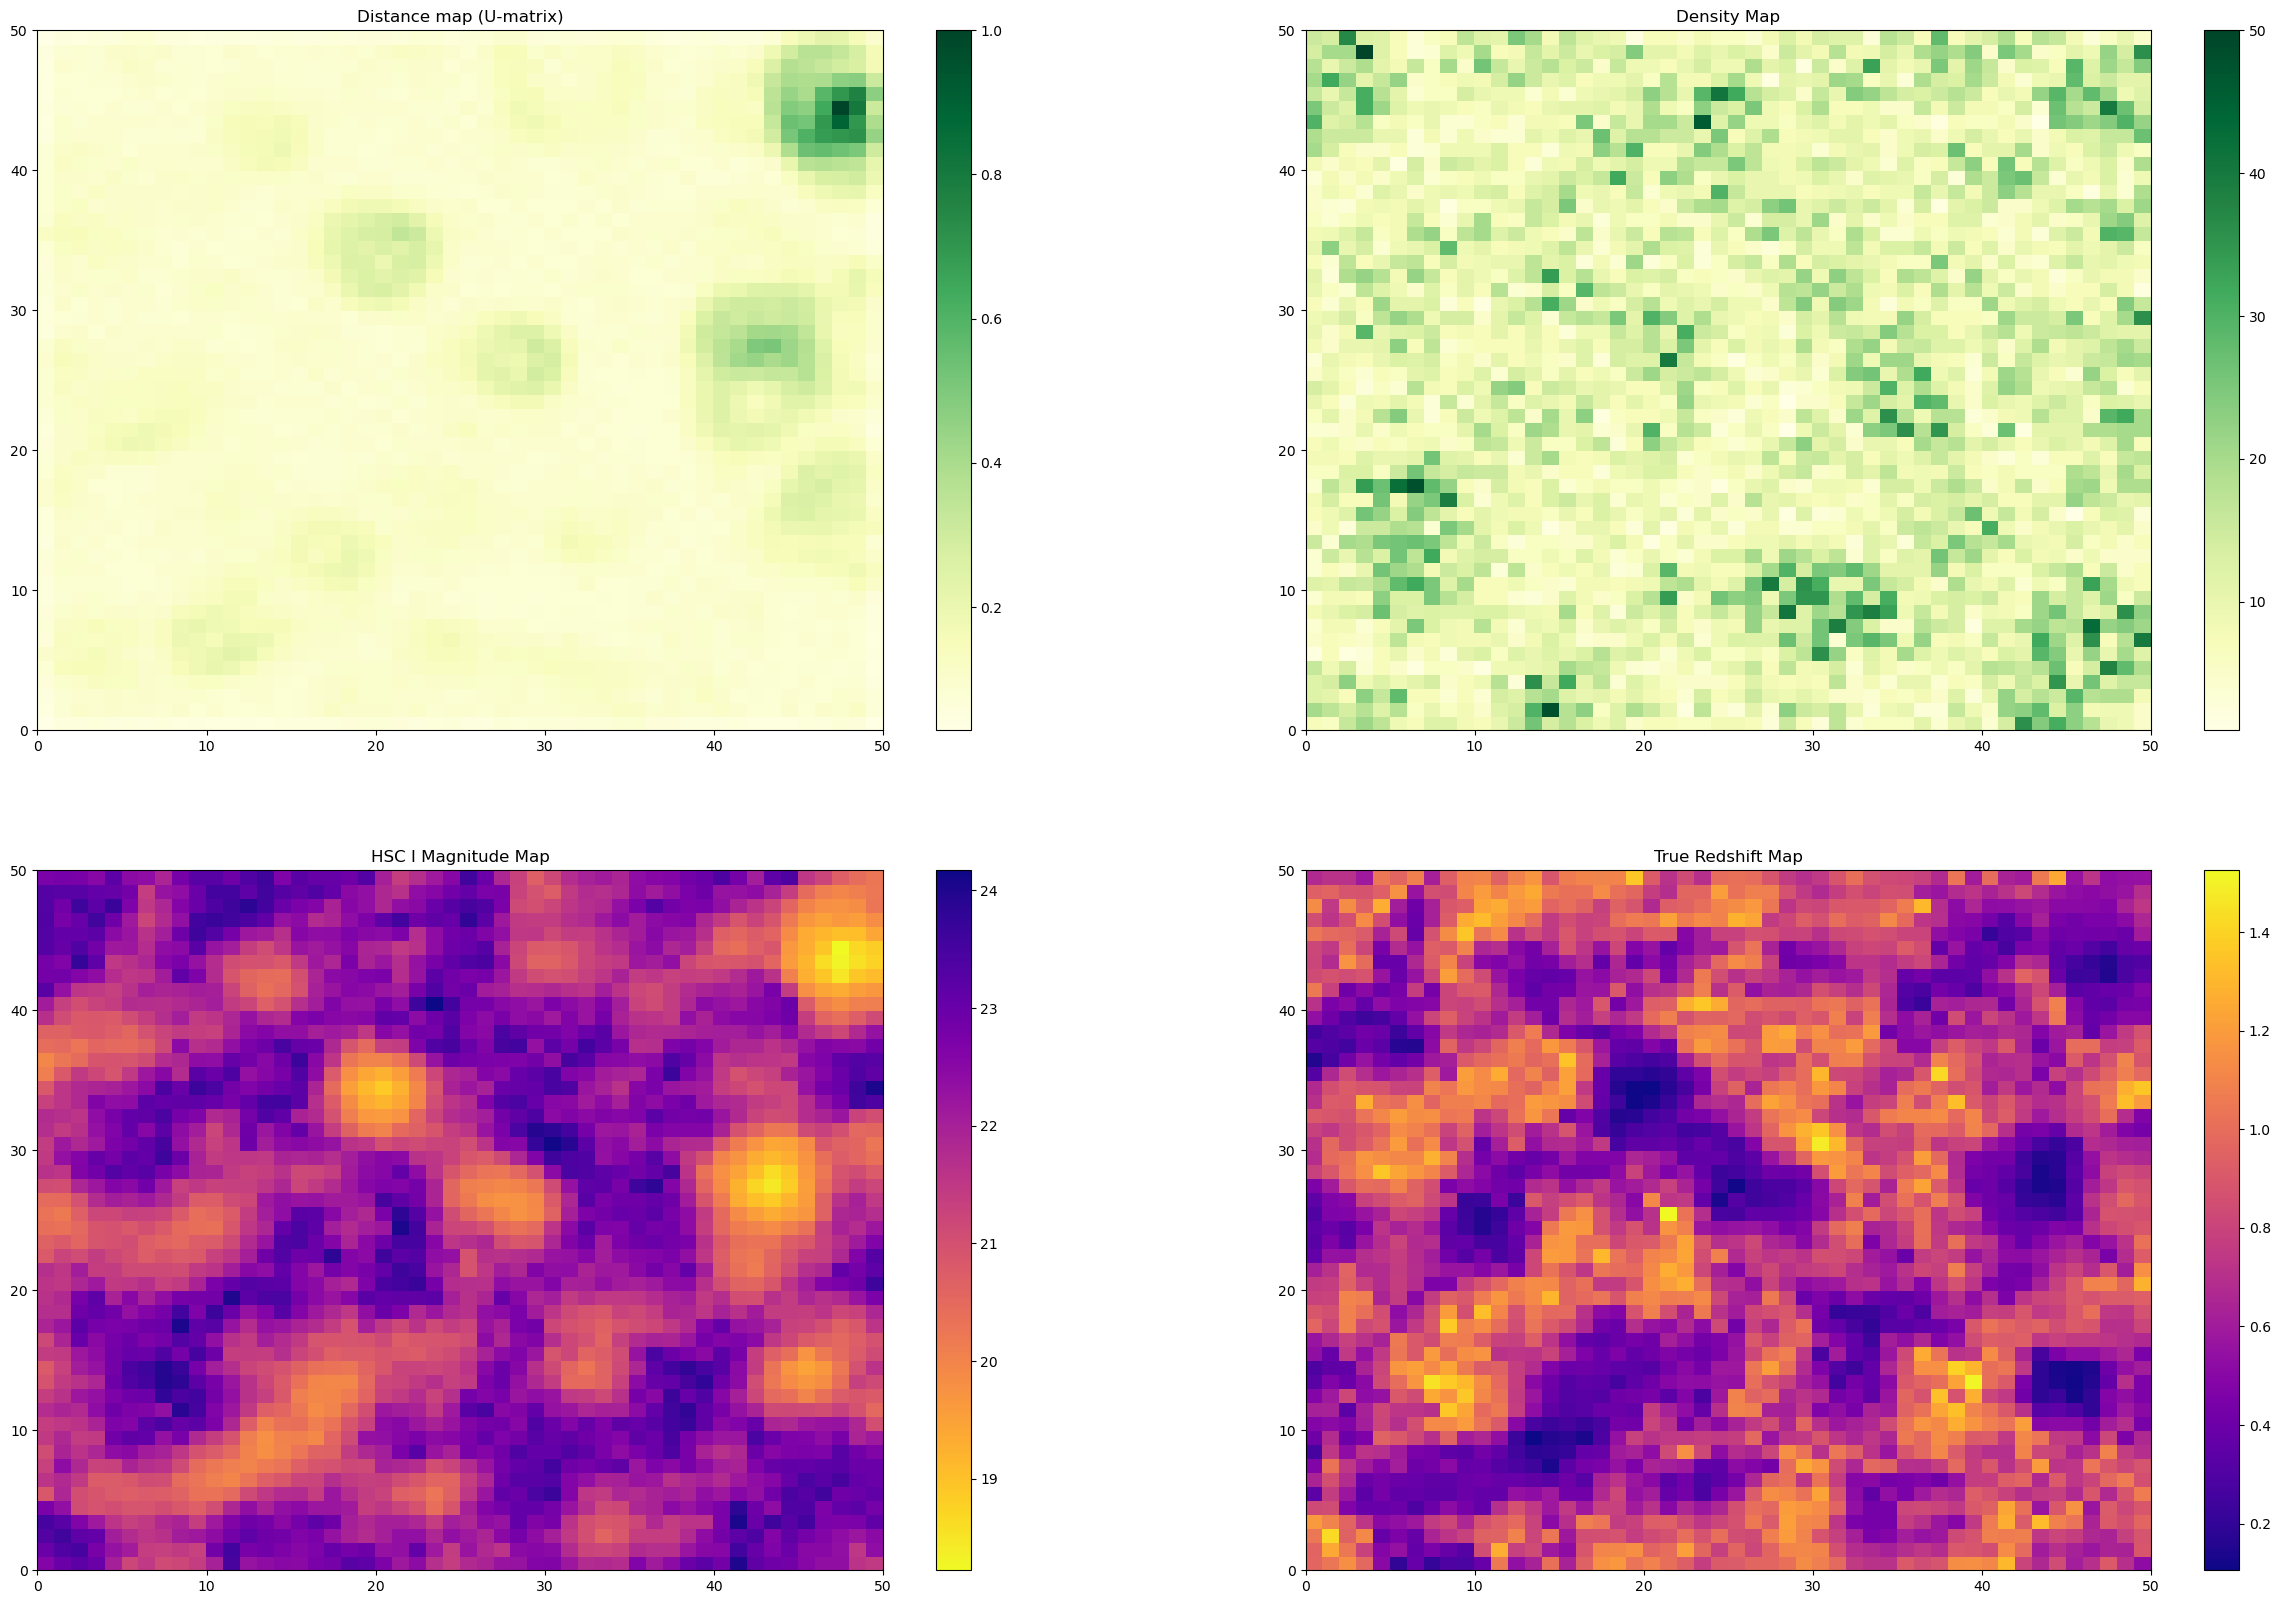

In [20]:
visual_map(dim = 50, sigma = 0.6, rate = 0.4, data = data, info_data = info_data, save = True)